# Tutorial 8.2: Competition via STDP
### Neuroscience goals:
- understand STDP in action
- discover how responses can become selective either by spontaneous activity breaking or selection of correlated inputs
### Computational goals:
- practice defining and manipulating distinct subsets of an array differently
- practice updating variables appropriately within a nested loop

### Overview
- will see STDP can produce a selective response in a neuron by preferentially strengthening one subset of its incoming synapses while weakinging all other inputs

## 1. generation of input spike trains and synaptic conductance
### a. 
- define 50 input spike trains, grouped into two subsets (a, b) of 25
- each subset follows a single time-varying rate ($r_a or r_b$) given by:

$$
r_{a,b}(t) = \frac{r_{max}}{2} [1+\sin(2\pi vt + \phi_{a,b})]
$$

with maximum rate of r_max = 60, frequency of osciallation of v = 20, and phase offsets of $\phi_a$ = 0 and $\phi_b$ = $\pi$

In [1261]:
import numpy as np
import matplotlib.pyplot as plt

In [1262]:
# parameters
r_max = 60
v = 20
phi_a = 0
phi_b = np.pi


In [1263]:
tmax = 0.5
dt = 0.1e-3
t = np.arange(0, tmax, dt)

## b.
- produce an array of input spikes, with 50 rows and a number of columns equal to the number of timesteps per trial (trial = 0.5s, dt = 0.1ms)
- produce spikes according to an inhomogenous (time-varying) Poisson process with rate $r_a(t)$ for rows 1-25, and rate $r_b(t)$ for rows 26-50
- each row represents a single trial of inputs, for which you ca

In [1264]:
# functions
def rate(t, phi):
    return (r_max / 2) * (1 + np.sin(2*np.pi * v * t + phi))

def generate_spike_train(phi, num_trials):
    spike_train = np.zeros((num_trials, len(t)))
    t_vals = np.arange(0, tmax, dt)
    rates = rate(t_vals, phi) * dt
    spike_train = np.random.rand(num_trials, len(t)) < rates
    return spike_train.astype(int)

spike_train_a = generate_spike_train(phi_a, 25)
spike_train_b = generate_spike_train(phi_b, 25)

input_spikes = np.vstack((spike_train_a, spike_train_b))

Text(0.5, 1.0, 'generated spike trains')

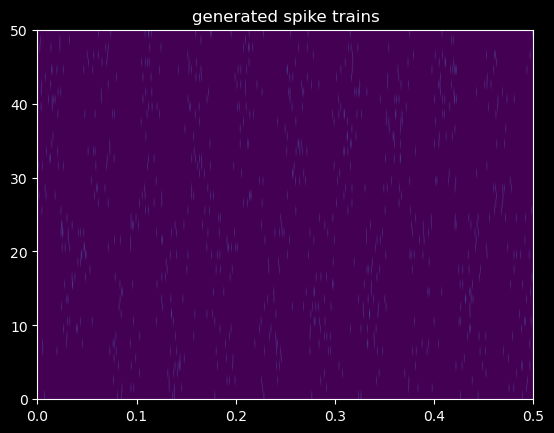

In [1265]:
plt.imshow(input_spikes, aspect='auto', cmap='viridis', extent=[0, tmax, 0, 50])
plt.title('generated spike trains')

### c.
- produce a vector of initial values of the synaptic strength, $G_i$, of each input synapse, labeled $i$ (one per distinct incoming spike train) with all entries sampled from a normal distribution with mean 500 pS and standard deviation 25 pS

In [1266]:
g_i = np.random.normal(500e-12, 25e-12, 50)

### d.
- produce a single vector representing the total (summed) synaptic excitatory conductance, $G_{syn}(t)$
- increment $G_{syn}(t)$ by an amount, $G_i$, at the time of each incoming spike at each input synapse, $i$
- between spikes, $G_{syn}(t)$ decays exponentially to zero, with a time constant $\tau_{syn}$ = 2ms

In [1267]:
tau_syn = 2e-3

def get_synaptic_conductance(input_spikes, g_i):
    g_syn = np.zeros_like(t)

    for timestep in range(1, len(t)):
        # exponential decay
        g_syn[timestep] = g_syn[timestep - 1] * np.exp(-dt / tau_syn)
        
        # add synaptic strength for each spike
        for i in range(len(g_i)):
            if input_spikes[i][timestep] == 1:
                g_syn[timestep] += g_i[i]

    return g_syn


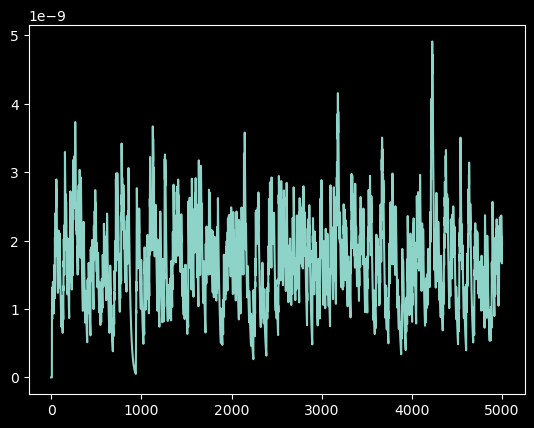

In [1268]:
test = get_synaptic_conductance(input_spikes, g_i)
plt.plot(test)

## 2. simulate spike train of LIF neuron receiving these inputs
### a. 
- simulate membrane potential of LIF neuron that follows:

$$
C_m\frac{dV}{dt} = G_L(E_L - V)+G_{syn}(E_{syn} - V)
$$

where if V > V_th then V -> V_reset

with parameters:
c_m = 100pF
g_l = 5nS
e_l = -70mV
e_syn = 0mV
v_th = -50mV
v_reset = -80V

initialized with V(0) = e_l

In [1269]:
# LIF parameters
c_membrane = 100e-12
g_leak = 5e-9
e_leak = -70e-3
e_syn = 0
v_thresh = -50e-3
v_reset = -80e-3
v_peak = 40e-3

In [1270]:
# LIF functions
def update_v(v, g_syn):
    dvdt = (g_leak * (e_leak - v) + g_syn * (e_syn - v)) / c_membrane
    return dvdt

def run_lif(g_syn):
    # initialize membrane potential array
    v = np.zeros_like(t)
    v[0] = e_leak
    spike_times = np.zeros_like(t)

    # through time
    for i in range(1, len(t)):
        dvdt = update_v(v[i - 1], g_syn[i - 1])
        v[i] = v[i - 1] + dvdt*dt

        # if spike
        if v[i] >= v_thresh:
            v[i] = v_reset
            v[i - 1] = v_peak
            spike_times[i] = 1
    
    return v, spike_times

### b.
- record all the spike times of the LIF neuron produced during the trial

### c. 
- plot the total synaptic conductance and membrane potential as a function of time

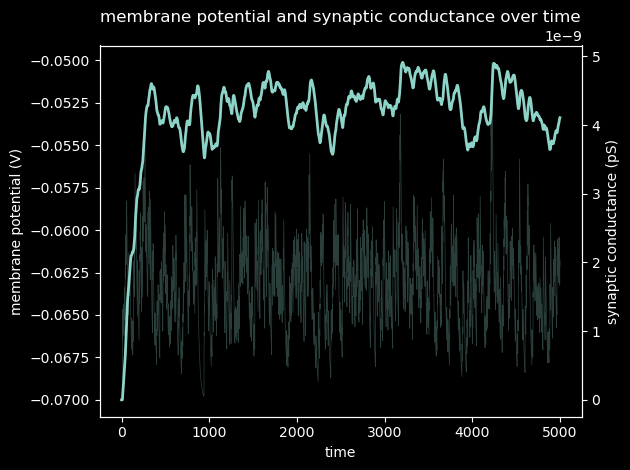

In [1271]:
g_syn = get_synaptic_conductance(input_spikes, g_i)
vm, spike_times = run_lif(g_syn)

fig, ax1 = plt.subplots()

# membrane potential
ax1.plot(vm, linewidth=2)
ax1.set_xlabel('time')
ax1.set_ylabel('membrane potential (V)')
ax1.tick_params('y')

# synaptic conductance
ax2 = ax1.twinx()
ax2.plot(g_syn, alpha=0.3, linewidth=0.5)
ax2.set_ylabel('synaptic conductance (pS)')

plt.title('membrane potential and synaptic conductance over time')
plt.tight_layout()

## 3. update input synaptic strengths using STDP rule after the trial using batch method
### a.
- for each input neuron and each input spike compare the time, $t_{pre}$, of the input (presynaptic) spike to the time, $t_{post}$ of each spike of the LIF neuron (postsynaptic)
- change the synaptic strength, $G_{i}$ of that input connection according to the rule:

$$
G_i\rightarrow G_i + \Delta G_{LTP}\exp(\frac{t_{pre} - t_{post}}{\tau_{LTP}}) \space\space\text{if} \space\space t_{pre} \lt t_{post}
$$

or

$$
G_i\rightarrow G_i + \Delta G_{LTD}\exp(\frac{t_{post} - t_{pre}}{\tau_{LTD}}) \space\space\text{if} \space\space t_{pre} \gt t_{post}
$$

with $\Delta G_{LTP} = 20\text{pS}, \Delta G_{LTD} = 25\text{pS}, \space\text{and} \tau_{LTP} = \tau_{LTD} = 20\text{ms}$

### b. 
- ensure synaptic strengths are neither less than zero nor greater than $G^{max} = 2\text{nS}$

### c. 
- record the mean synaptic strength for each set of 25 inputs and plot the set of synaptic strengths as a function of input number

### d.
- explain how the synaptic strengths change across trials and how the changing synaptic strengths impact the time variation of the input conductance and the pattern of the LIF neuron's spike train. repeat the simulation and explain any differences

In [1272]:
post_spike_times = np.where(spike_times)[0]
pre_spike_times = np.where(input_spikes[0] == 1)[0]

for pre in pre_spike_times:
    for post in post_spike_times:
        if pre < post:
            print('')

In [1273]:
# parameters
delta_g_ltp = 20e-12
delta_g_ltd = 25e-12
tau_ltp = 20e-3
tau_ltd = 20e-3
g_max = 2e-9

def update_weights(g_i, input_spikes, spike_times):
    # post synaptic spike times
    post_spike_times = np.where(spike_times)[0]

    for i in range(len(g_i)):
        pre_spike_times = np.where(input_spikes[i] == 1)[0]

        for t_pre in pre_spike_times:
            for t_post in post_spike_times:
                t_pre /= 1000
                t_post /= 1000
                if t_pre < t_post:
                    g_i[i] += delta_g_ltp * np.exp((t_pre - t_post) / tau_ltp)
                elif t_pre > t_post:
                    g_i[i] += delta_g_ltd * np.exp((t_post - t_pre) / tau_ltd)
        g_i[i] = np.clip(g_i[i], 0, g_max)
    return g_i

g_i = update_weights(g_i, input_spikes, spike_times)

In [1274]:
def mean_synaptic_strength(g_i, set_size=1):
    num_sets = len(g_i) // set_size
    means = np.zeros(num_sets)

    for i in range(num_sets):
        start = i * set_size
        end = (i + 1) * set_size
        means[i] = np.mean(g_i[start:end])

    return means


In [1275]:
means = mean_synaptic_strength(g_i)
mean_groups = mean_synaptic_strength(g_i, 25)

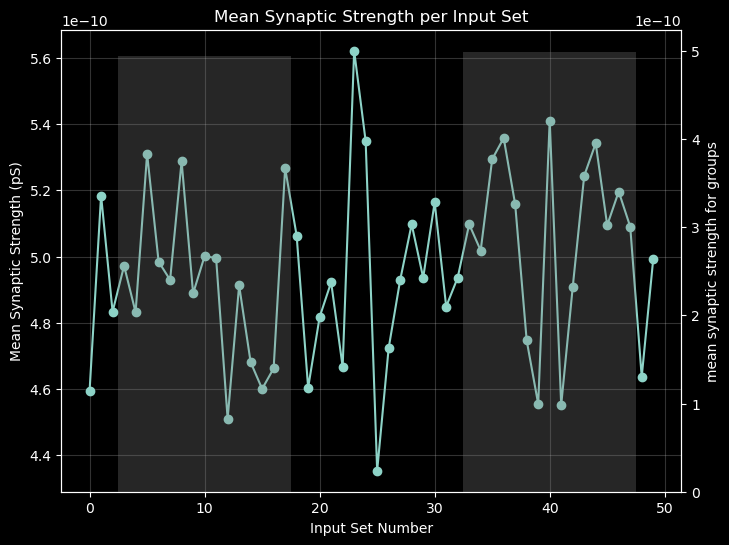

In [1276]:
# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(means, '-o', label='neuron')
ax2 = ax1.twinx()
ax2.bar([10, 40], mean_groups, width=15, alpha=0.3, color='gray', label='groups')
ax2.set_ylabel('mean synaptic strength for groups')
ax1.set_xlabel('Input Set Number')
ax1.set_ylabel('Mean Synaptic Strength (pS)')
ax1.set_title('Mean Synaptic Strength per Input Set')
ax1.grid(True, alpha=0.2)

## 4. train the system
### a. 
- repeat 1-3 for 200 trials, but only producing plots every 20 trials

### b. 
- plot the mean synaptic strengths of the two sets of 25 inputs as a function of trial number

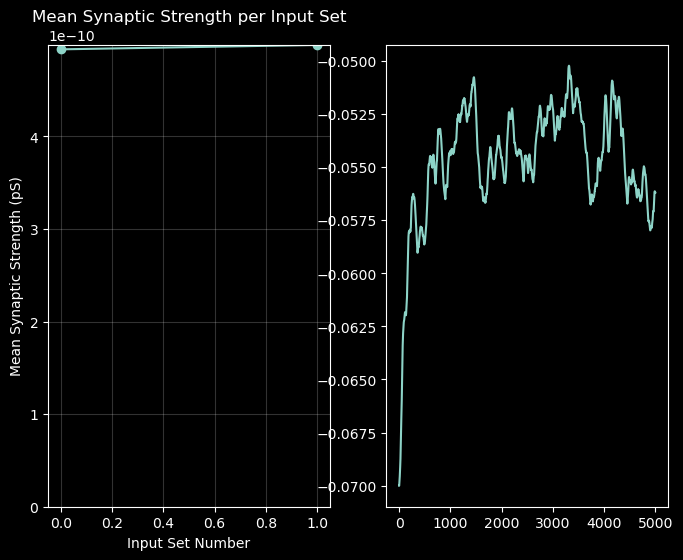

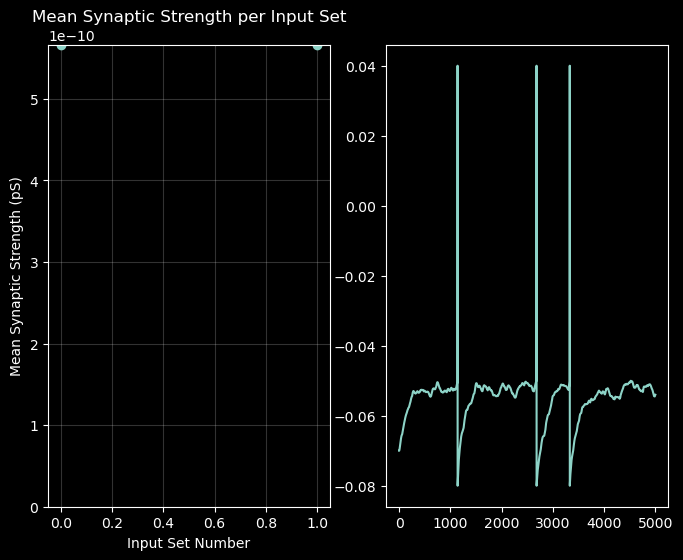

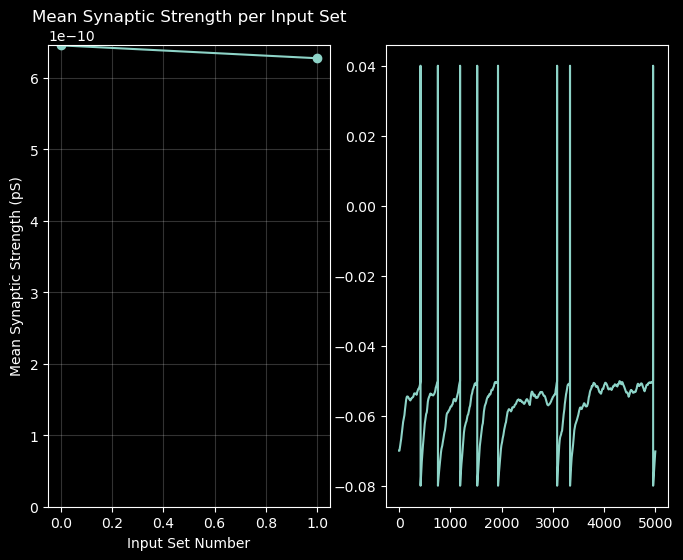

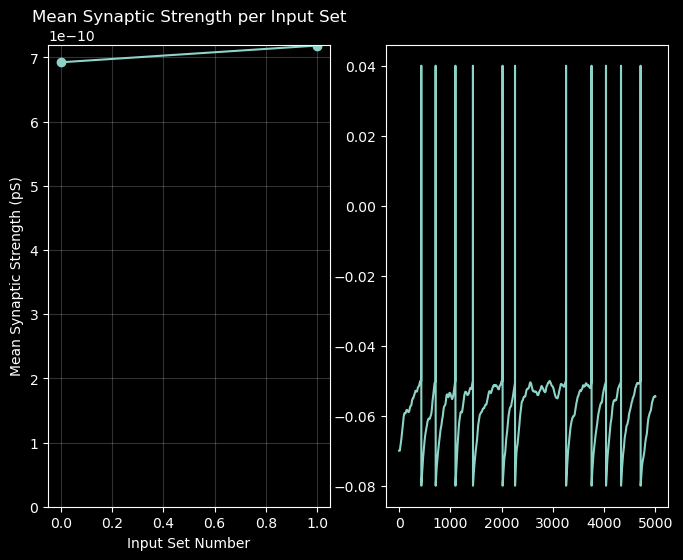

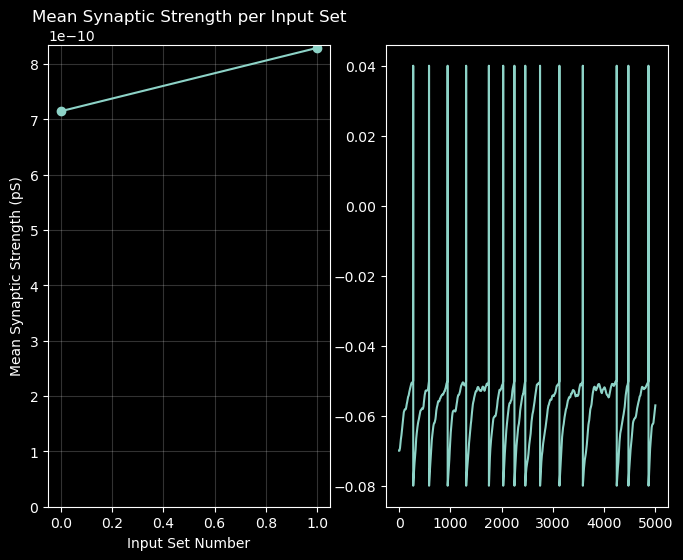

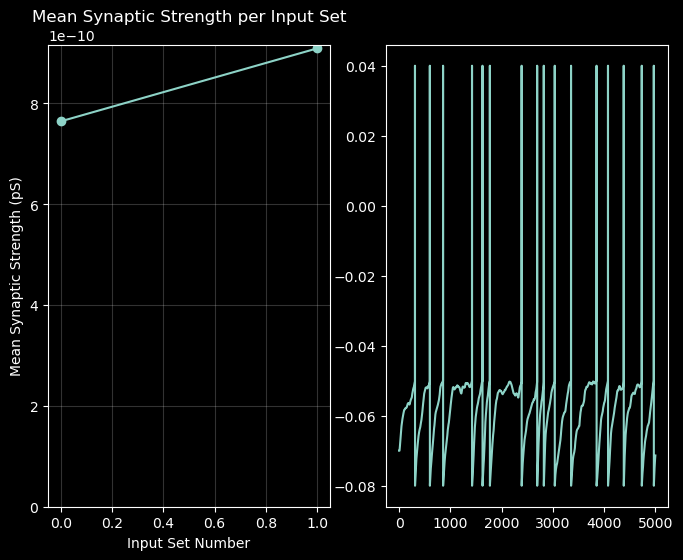

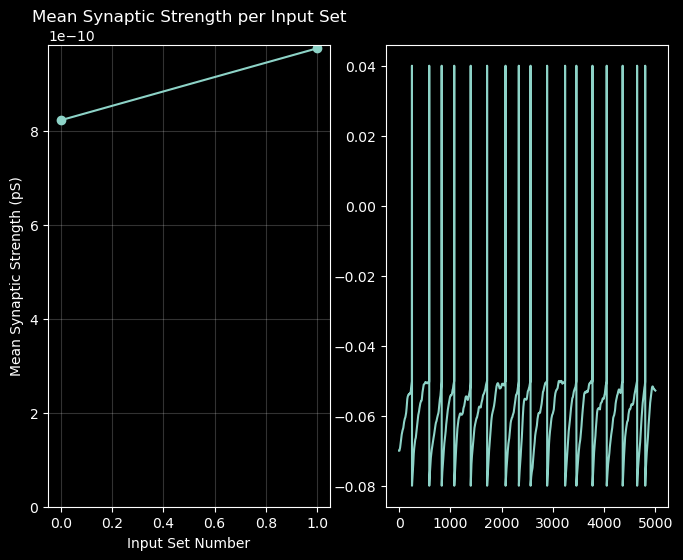

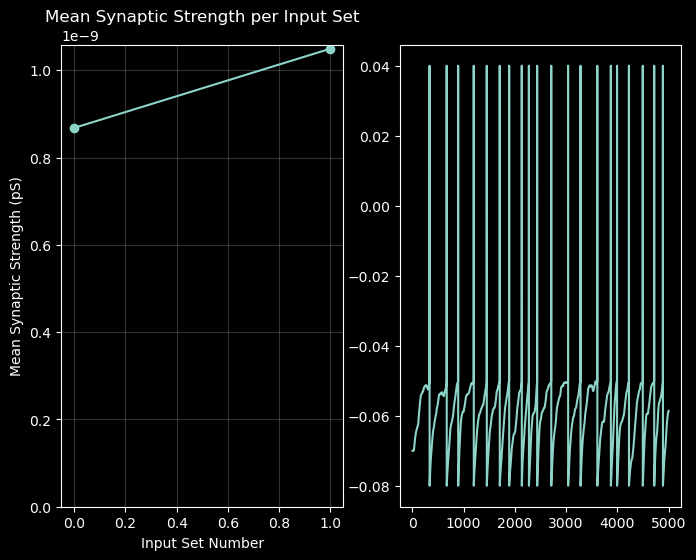

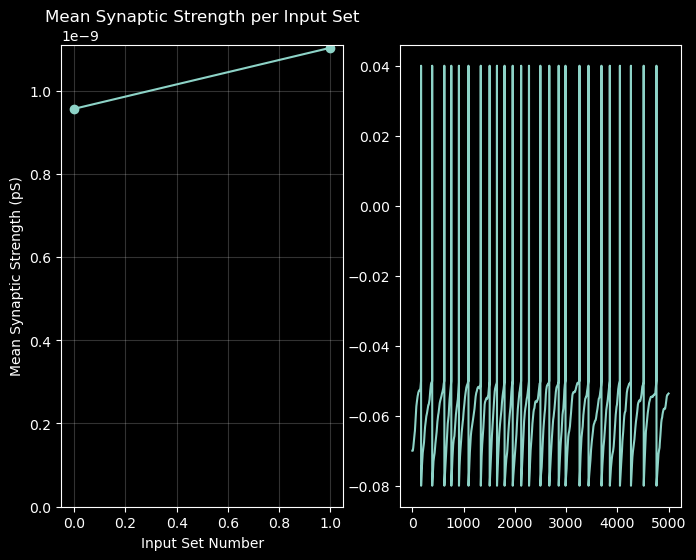

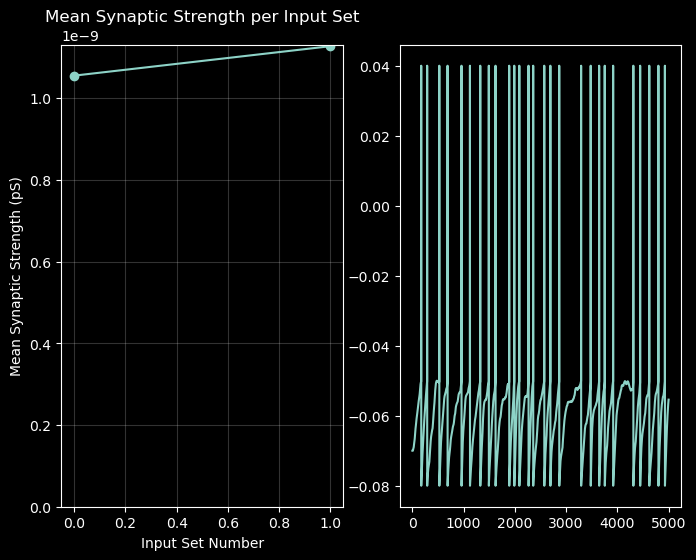

In [1277]:
all_mean_strengths = []

for trial in range(200):
    # get inputs
    spike_train_a = generate_spike_train(phi_a, 25)
    spike_train_b = generate_spike_train(phi_b, 25)
    input_spikes = np.vstack((spike_train_a, spike_train_b))

    # simulate LIF neuron
    g_syn = get_synaptic_conductance(input_spikes, g_i)
    vm, spike_times = run_lif(g_syn)

    # update weights 
    g_i = update_weights(g_i, input_spikes, spike_times)

    # store means synaptic strengths
    means = mean_synaptic_strength(g_i, 25)
    all_mean_strengths.append(means)

    # plot every 20 trials
    if trial % 20 == 0:

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

        ax1.plot(means, '-o', label='neuron')
        ax1.set_xlabel('Input Set Number')
        ax1.set_ylabel('Mean Synaptic Strength (pS)')
        ax1.set_ylim(0)
        ax1.set_title('Mean Synaptic Strength per Input Set')
        ax1.grid(True, alpha=0.2)

        ax2.plot(vm)
        plt.show()

## 5. alter phase offsets
- repeat 1-4, using a phase offset that alternates across trials, such that $\phi_a = 0$ on all trials, but $\phi_b = \pi / 2$ on odd trials and $-\pi / 2$ on even trials
- the sign reversal represents moving stimuli, or eyes moving in either direction

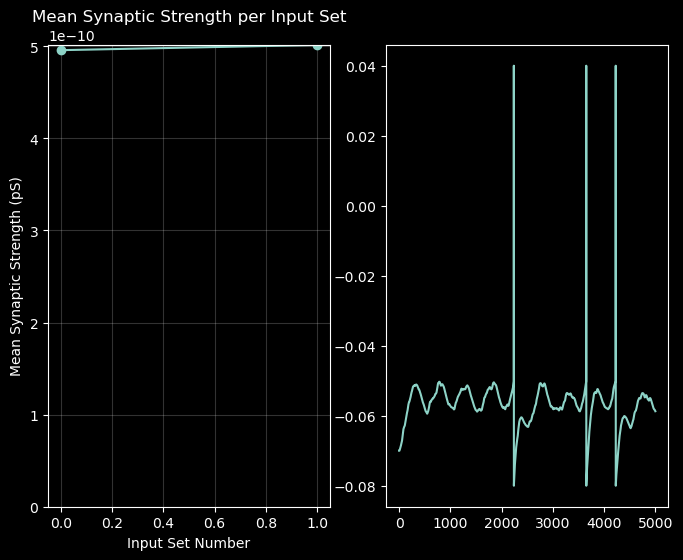

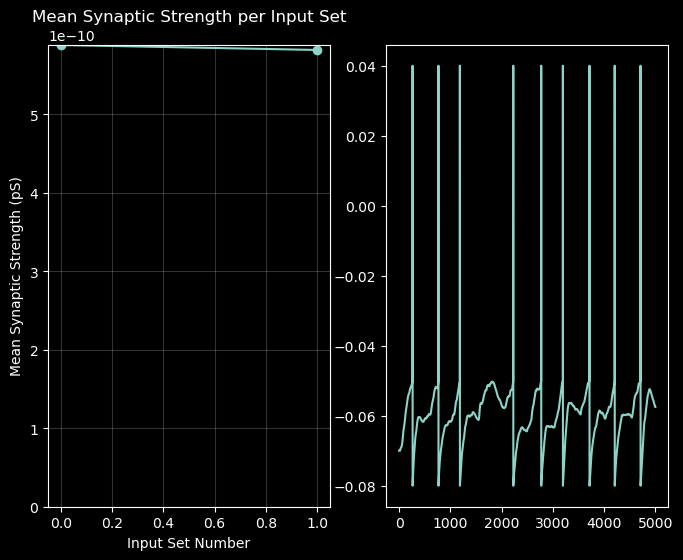

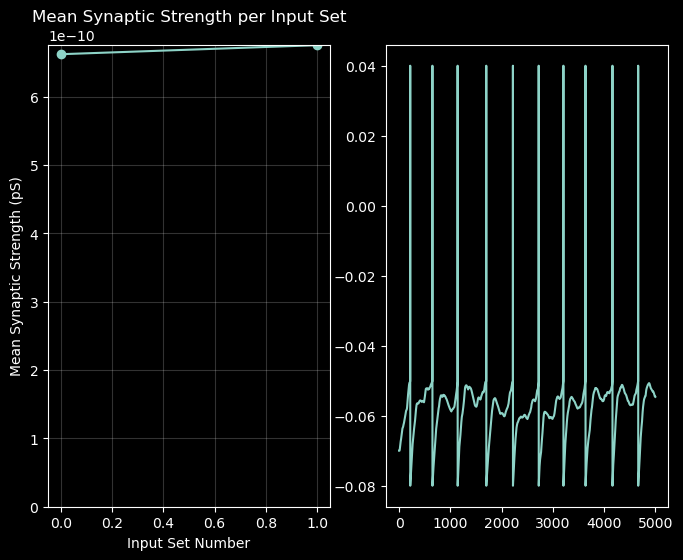

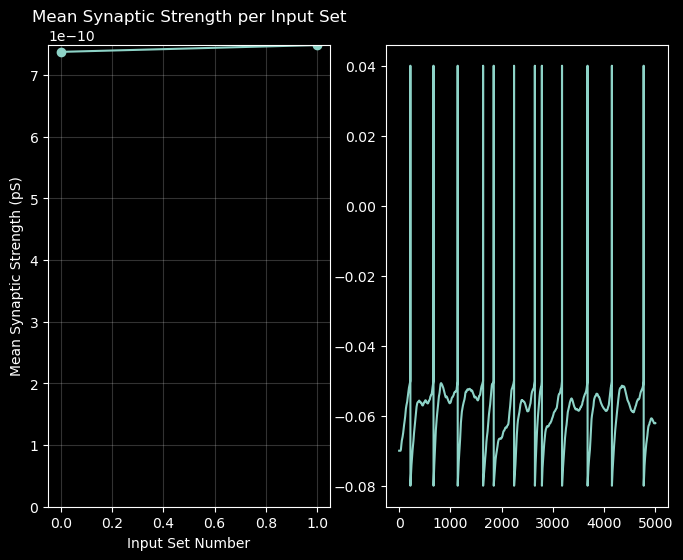

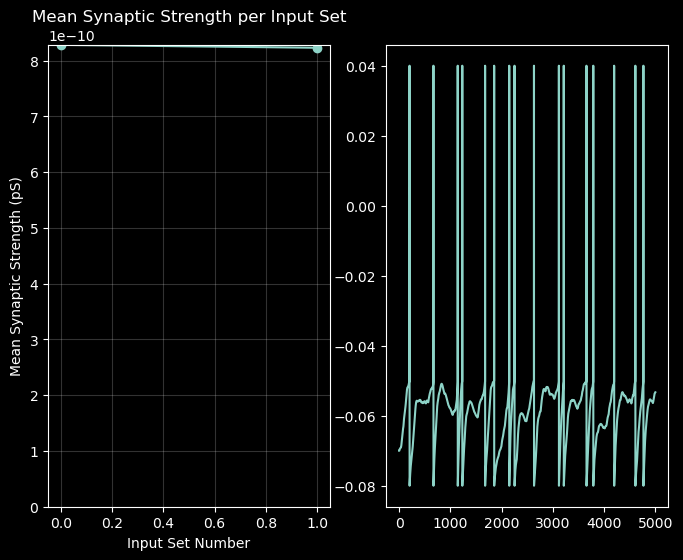

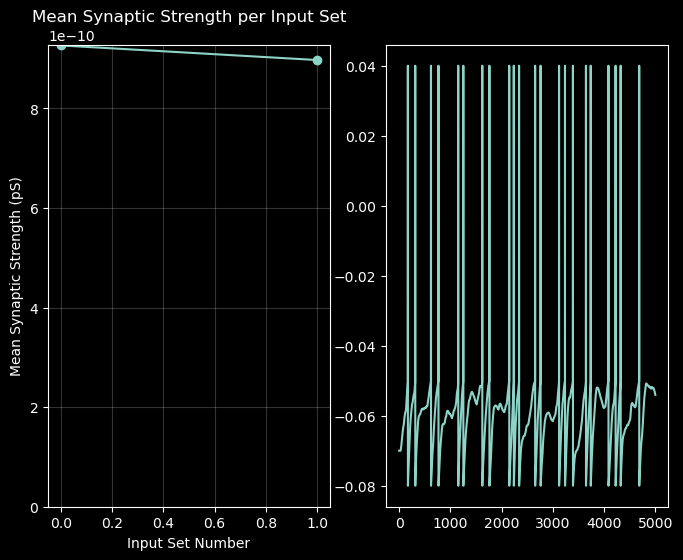

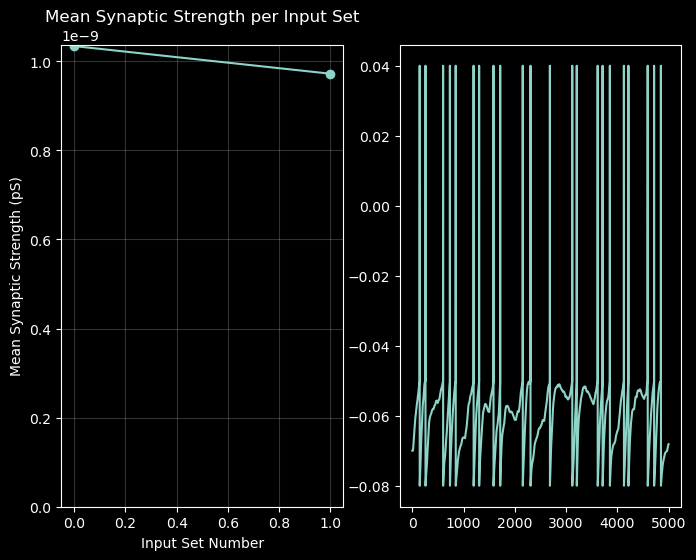

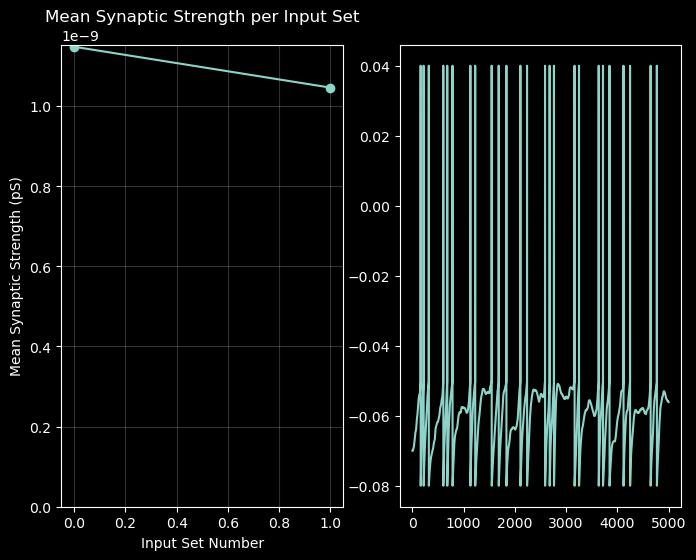

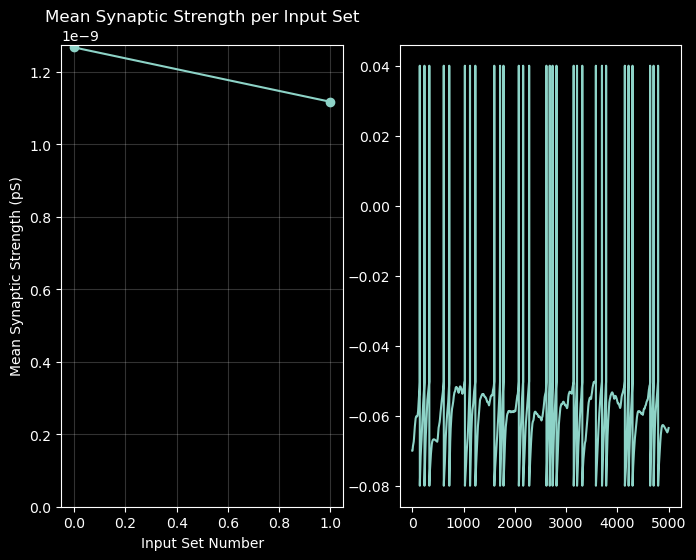

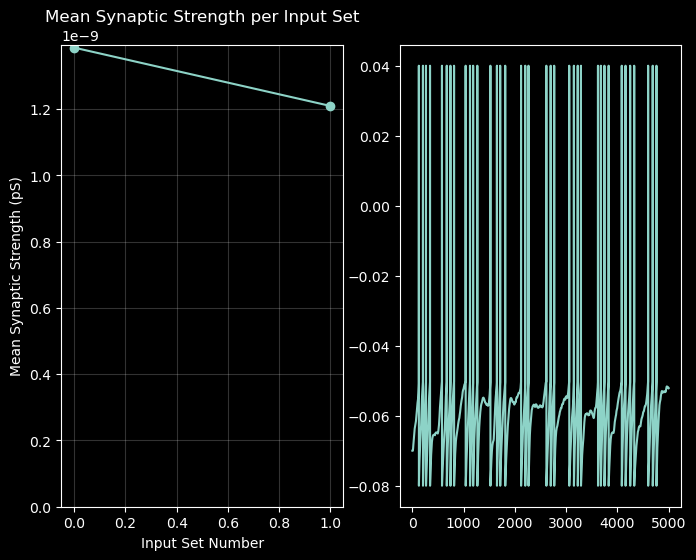

In [1278]:
all_mean_strengths = []
g_i = np.random.normal(500e-12, 25e-12, 50)

for trial in range(200):
    # get inputs
    phi_b = -np.pi/2 if trial % 2 == 0 else np.pi/2
        
    spike_train_a = generate_spike_train(phi_a, 25)
    spike_train_b = generate_spike_train(phi_b, 25)
    input_spikes = np.vstack((spike_train_a, spike_train_b))

    # simulate LIF neuron
    g_syn = get_synaptic_conductance(input_spikes, g_i)
    vm, spike_times = run_lif(g_syn)

    # update weights 
    g_i = update_weights(g_i, input_spikes, spike_times)

    # store means synaptic strengths
    means = mean_synaptic_strength(g_i, 25)
    all_mean_strengths.append(means)

    # plot every 20 trials
    if trial % 20 == 0:

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

        ax1.plot(means, '-o', label='neuron')
        ax1.set_xlabel('Input Set Number')
        ax1.set_ylabel('Mean Synaptic Strength (pS)')
        ax1.set_ylim(0)
        ax1.set_title('Mean Synaptic Strength per Input Set')
        ax1.grid(True, alpha=0.2)

        ax2.plot(vm)
        plt.show()

# 6. correlated vs uncorrelated stimuli
### a. 
- the phase offset of each oscillation producing the 50 inputs will vary, so produce a set of 50 rate vectors:

$$

r_i (t) = \frac{r_max}{2} [ 1 + \sin(2\pi vt \pm \phi_i)]

$$

where $\phi_i$ = 0 for $1 \le i \le 10$, and $\phi_i$ selected as a random number from 0 to $2\pi$ for $ i \gt 10$

on odd trials, set the phase offset as $+ \phi_i$, and on even trials as $-\phi_i$

use frequency of v = 10Hz

### b. 
plot the mean synaptic strength of the correlated group separately from the mean synaptic strength of the uncorrelated inputs, as a function of trial numberx

In [1279]:
v = 10

def get_rate_vector(i, trial):
    sign = 1 if trial % 2 == 0 else -1

    if 1 <= i <= 10:
        phi_i = 0
    else:
        phi_i = np.random.uniform(0, 2*np.pi)

    r_i = rate(t, sign*phi_i)
    return r_i

def generate_spike_train(phi, num_trials):
    rates = rate(t, phi) * dt
    spike_train = np.random.rand(num_trials, len(t)) < rates
    return spike_train.astype(int)

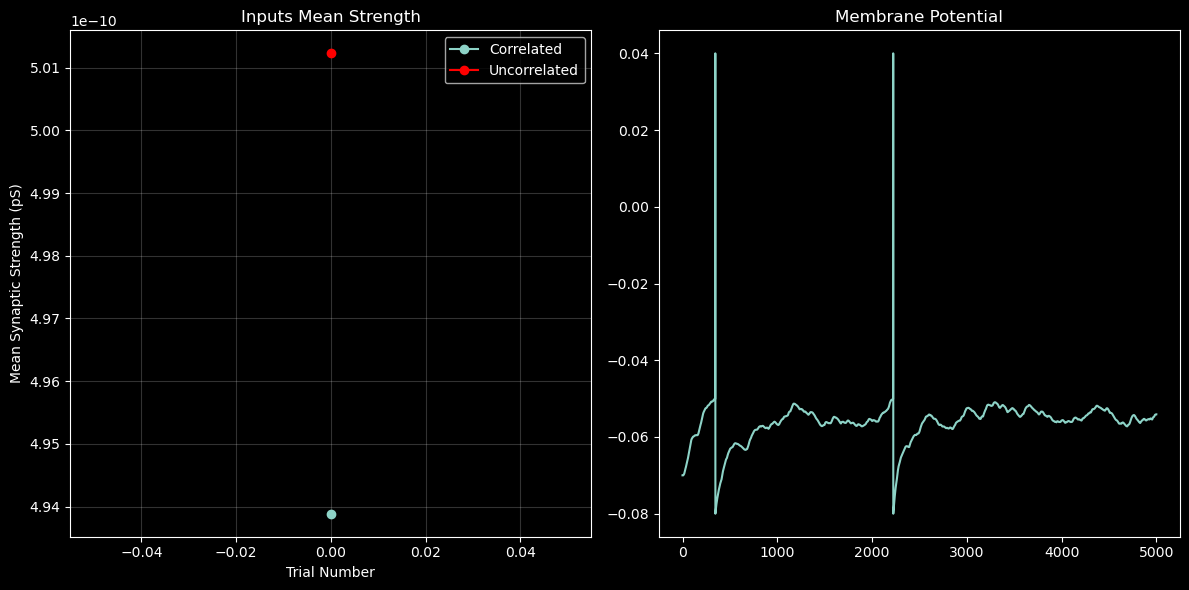

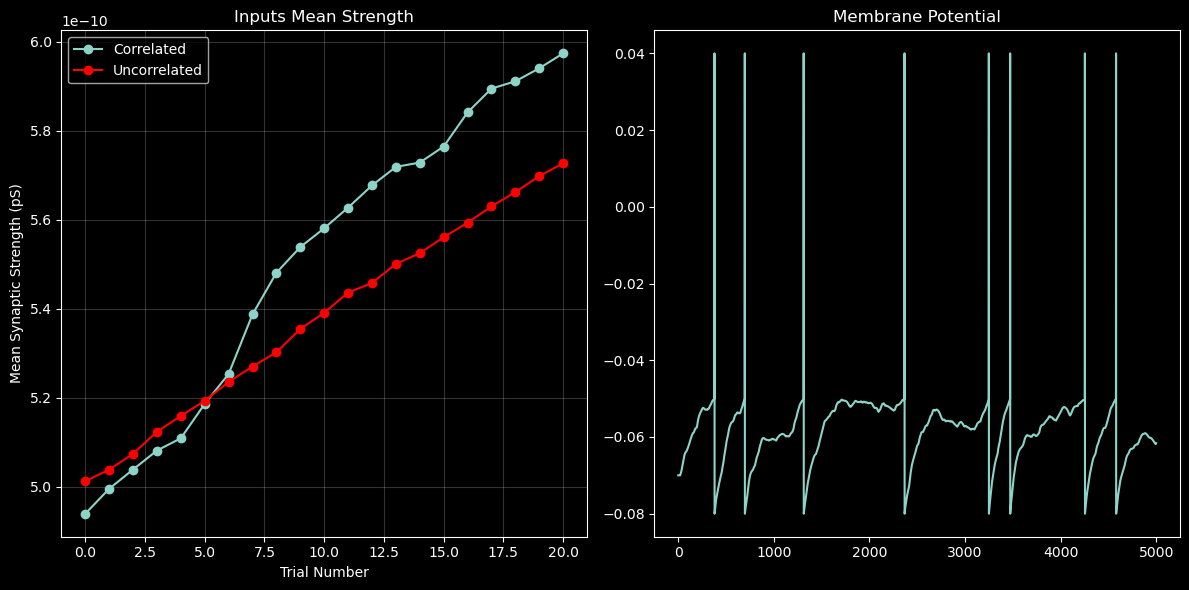

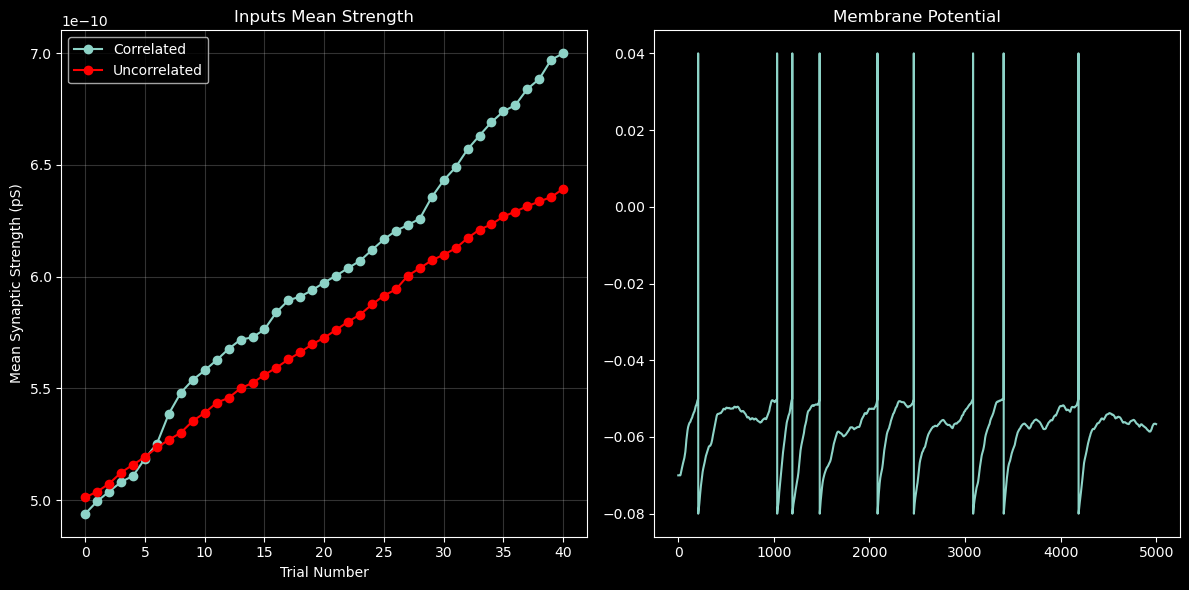

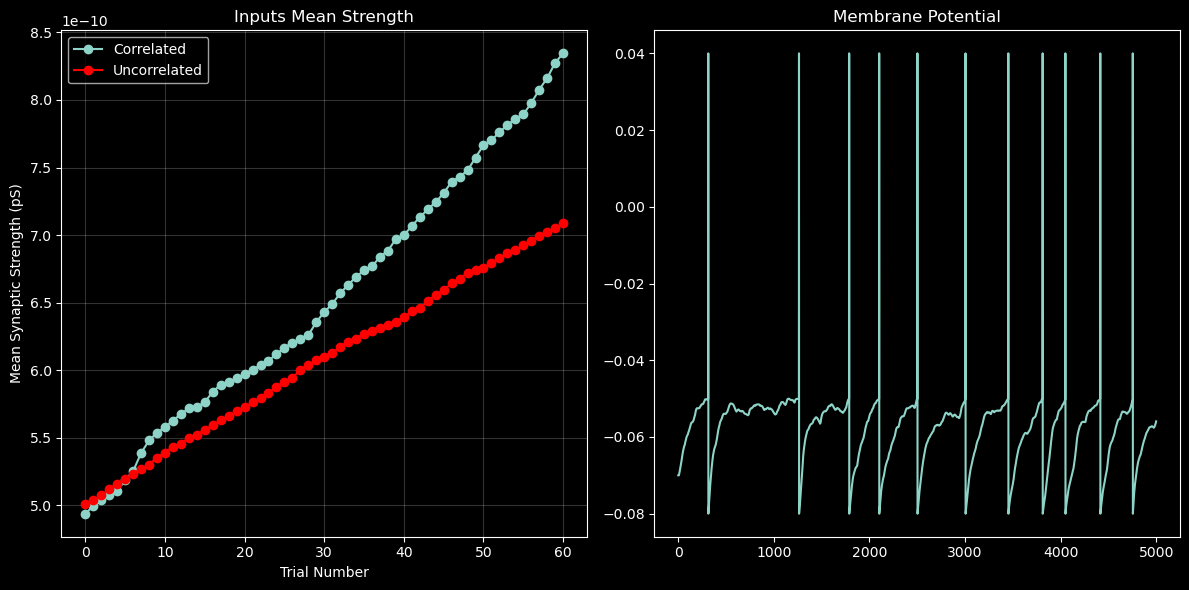

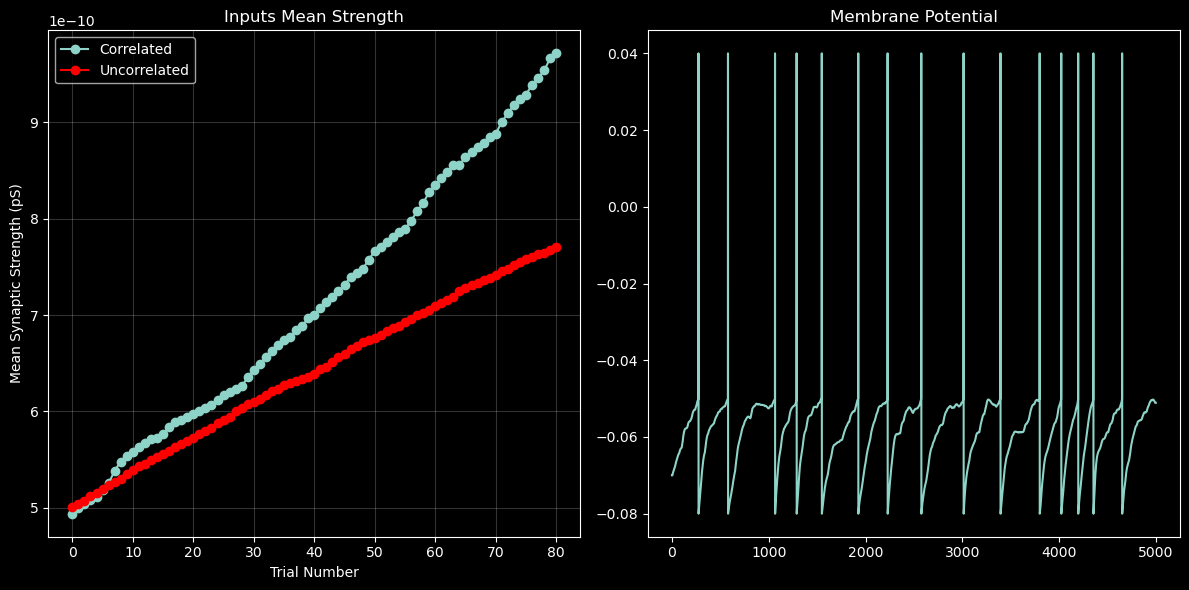

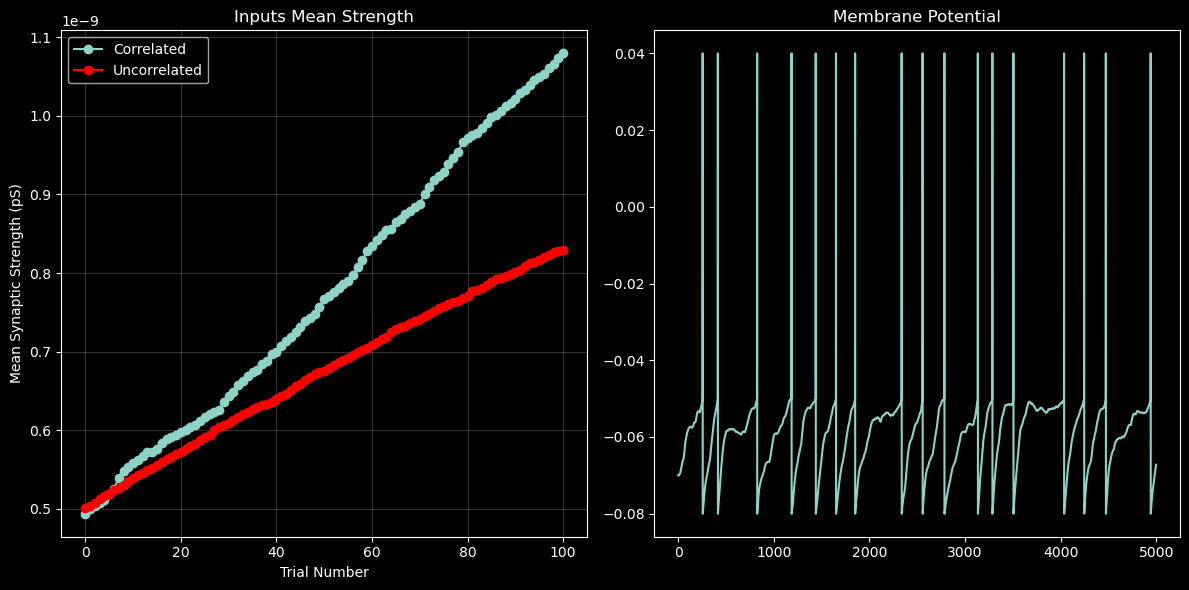

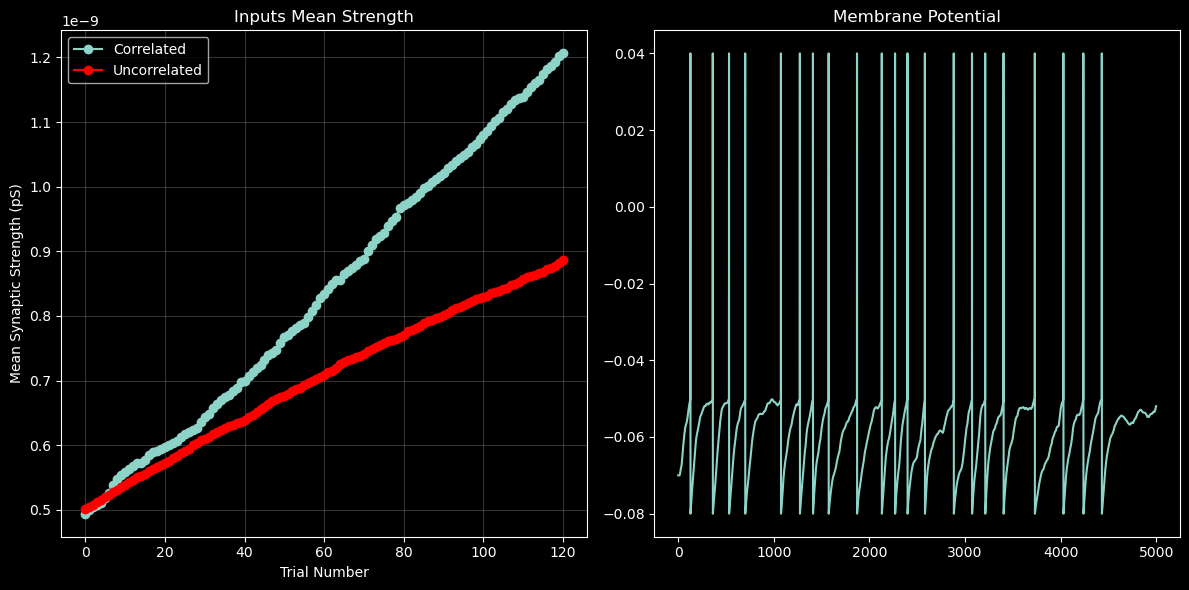

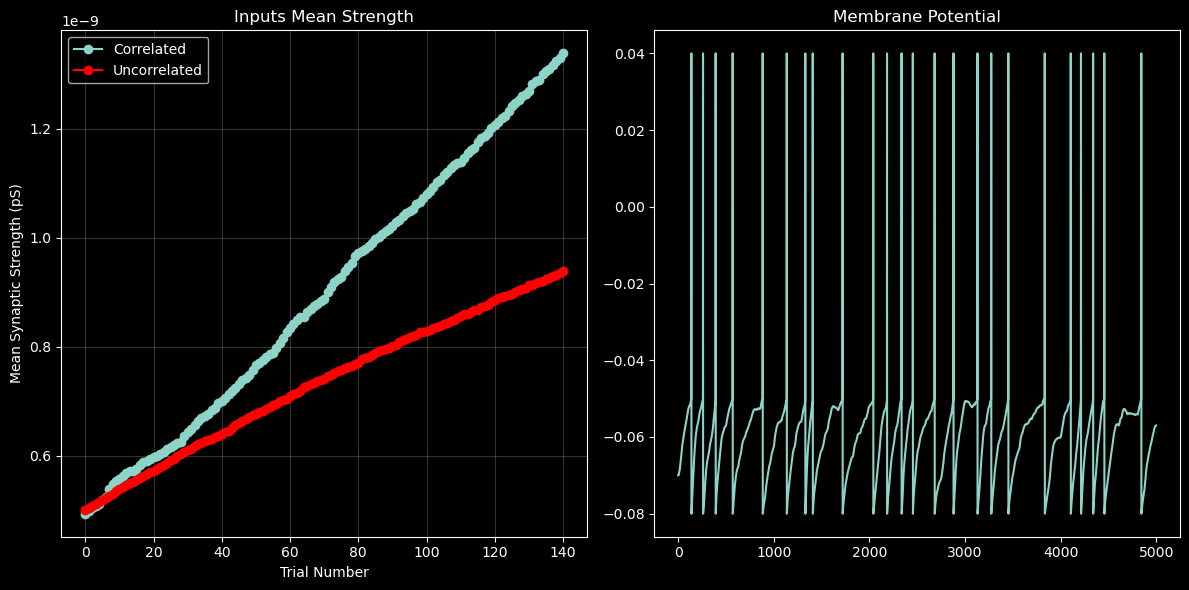

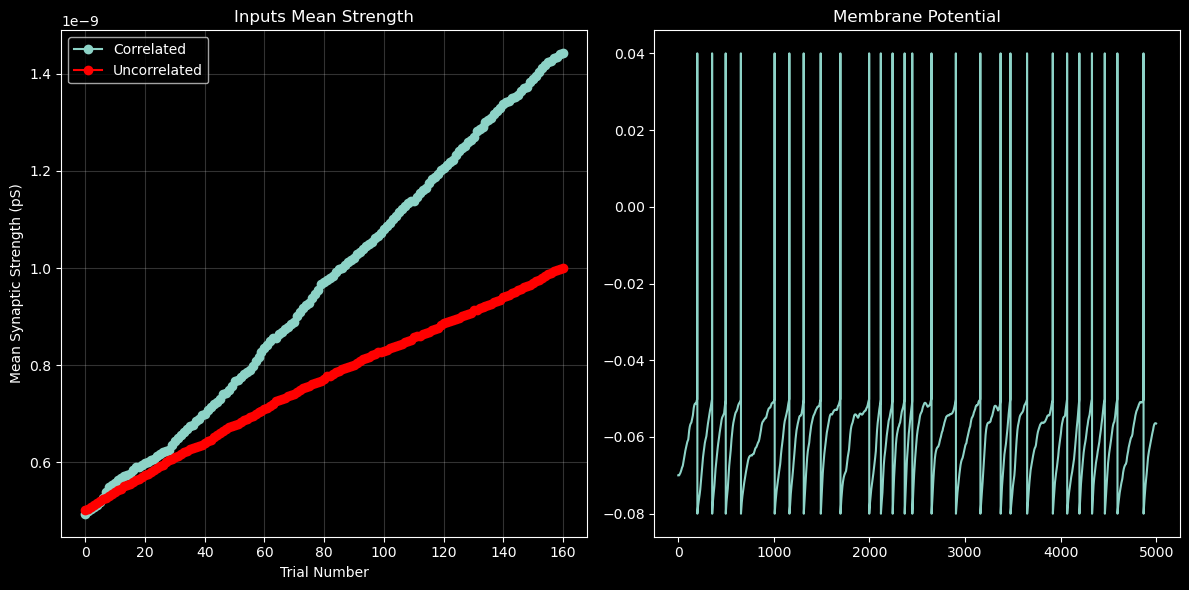

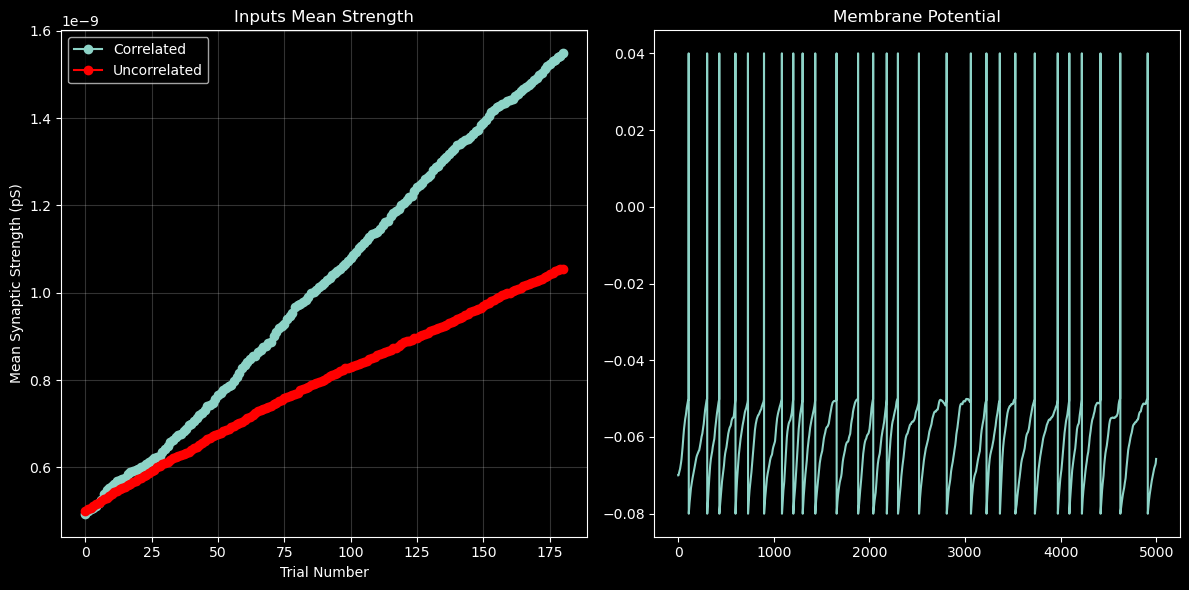

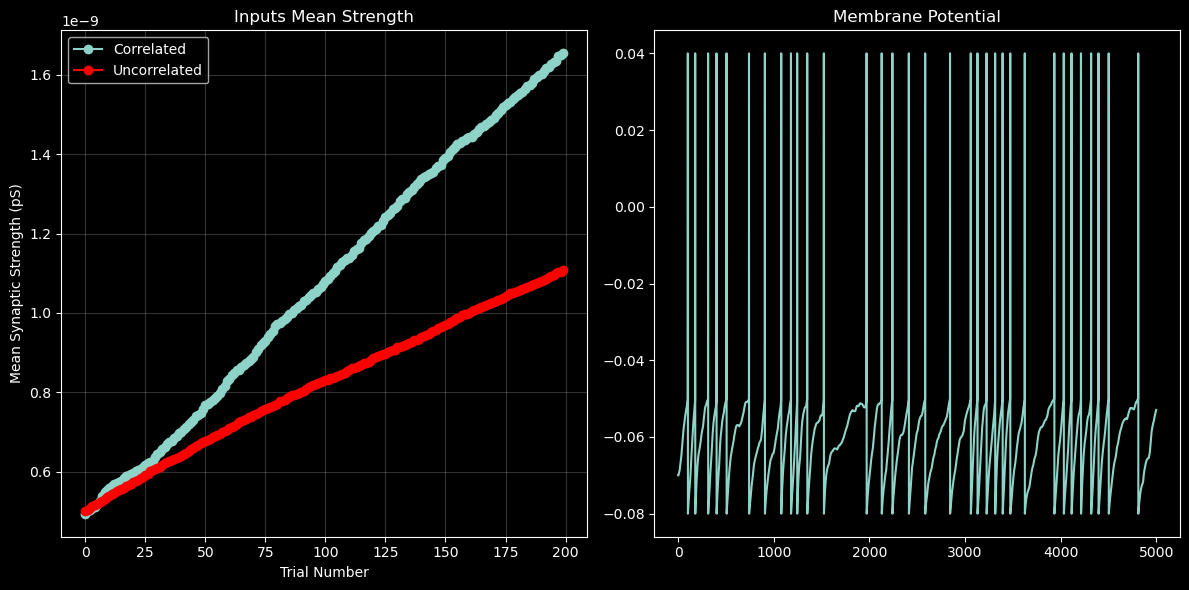

In [1280]:
n_inputs = 50
all_mean_strengths_correlated = []
all_mean_strengths_uncorrelated = []
g_i = np.random.normal(500e-12, 25e-12, 50)

for trial in range(200):
    input_spikes = np.zeros((50, len(t)))
    for i in range(50):
        rate_vector = get_rate_vector(i+1, trial)
        input_spikes[i, :] = np.random.rand(len(t)) < rate_vector * dt


    # simulate LIF neuron
    g_syn = get_synaptic_conductance(input_spikes, g_i)
    vm, spike_times = run_lif(g_syn)

    # update weights 
    g_i = update_weights(g_i, input_spikes, spike_times)

    # store means synaptic strengths
    means = mean_synaptic_strength(g_i, 25)
    all_mean_strengths.append(means)

    correlated_mean_strength = np.mean(g_i[:10])  # first 10 inputs
    uncorrelated_mean_strength = np.mean(g_i[10:])  # remaining inputs
    
    all_mean_strengths_correlated.append(correlated_mean_strength)
    all_mean_strengths_uncorrelated.append(uncorrelated_mean_strength)

    # plot every 20 trials
    if trial % 20 == 0 or trial == 199:  # added condition to also plot the last trial
        
        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(all_mean_strengths_correlated, '-o', label='Correlated')
        ax1.plot(all_mean_strengths_uncorrelated, '-o', label='Uncorrelated', color='r')

        ax1.set_xlabel('Trial Number')
        ax1.set_ylabel('Mean Synaptic Strength (pS)')
        ax1.set_title('Inputs Mean Strength')
        ax1.grid(True, alpha=0.2)
        ax1.legend()

        ax2.plot(vm)
        ax2.set_title('Membrane Potential')
        
        plt.tight_layout()  # Adjusts subplot params for better layout
        plt.show()



### c. 
plot the final synaptic strength of each neuron as a function of its phase offset

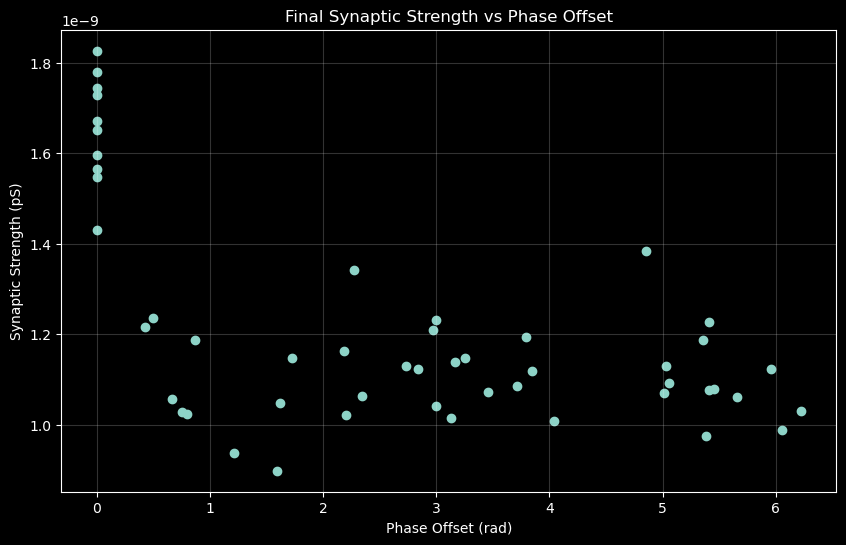

In [1281]:
phase_offsets = [0] * 10 + [np.random.uniform(0, 2*np.pi) for _ in range(40)]
final_strengths = g_i

plt.figure(figsize=(10, 6))
plt.scatter(phase_offsets, final_strengths)
plt.title('Final Synaptic Strength vs Phase Offset')
plt.xlabel('Phase Offset (rad)')
plt.ylabel('Synaptic Strength (pS)')
plt.grid(True, alpha=0.2)
plt.show()
